## Hounsfield Units Clipping

In [112]:
import os
import shutil  # For copying files that don't have pixel data
import glob
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

##############################
# DICOM Processing Functions #
##############################

def process_dicom_file(input_filepath, output_filepath, hu_range=(-10000, 3000)):
    """
    Preprocess a single DICOM file:
      - Read the DICOM file.
      - If it lacks pixel data, copy it as-is.
      - Otherwise:
          - Convert raw pixel data to Hounsfield Units (HU).
          - Clip the HU values to the specified range.
          - Update the dataset and save the file.
    """
    ds = pydicom.dcmread(input_filepath)
    
    # If the file doesn't contain pixel data, copy it directly.
    if "PixelData" not in ds:
        shutil.copy(input_filepath, output_filepath)
        return

    # Convert pixel data to float32 for computation.
    pixel_array = ds.pixel_array.astype(np.float32)
    rescale_slope = float(ds.get('RescaleSlope', 1))
    rescale_intercept = float(ds.get('RescaleIntercept', 0))

    # Convert to Hounsfield Units (HU) and clip to the specified range.
    hu_array = pixel_array * rescale_slope + rescale_intercept
    hu_array = np.clip(hu_array, hu_range[0], hu_range[1])

    # Convert back to int16 and update the dataset.
    clipped_pixels = hu_array.astype(np.int16)
    ds.PixelData = clipped_pixels.tobytes()
    ds.PixelRepresentation = 1  # 1 means signed integers
    ds.save_as(output_filepath)

def process_dicom_folder(input_folder, output_folder, hu_range=(-10000, 3000)):
    """
    Process all DICOM files in the input folder and save the results to the output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.dcm'):
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, filename)
            try:
                process_dicom_file(input_filepath, output_filepath, hu_range)
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

##########################################
# DICOM Sorting and Slice Selection Code #
##########################################

def get_slice_z(filepath):
    """
    Extract a z-coordinate for sorting from a DICOM file.
    Prioritizes ImagePositionPatient (3rd element), then SliceLocation, then InstanceNumber.
    """
    try:
        ds = pydicom.dcmread(filepath, stop_before_pixels=True)
        if 'ImagePositionPatient' in ds:
            return float(ds.ImagePositionPatient[2])
        elif 'SliceLocation' in ds:
            return float(ds.SliceLocation)
        elif 'InstanceNumber' in ds:
            return float(ds.InstanceNumber)
    except Exception:
        pass
    return 0.0

def load_and_sort_dicom_files(folder_path):
    """
    Load all DICOM file paths from the given folder and sort them based on slice position.
    """
    dicom_files = glob.glob(os.path.join(folder_path, "*.dcm"))
    # Pair each file with its z-coordinate and sort by that value.
    file_z_pairs = [(fp, get_slice_z(fp)) for fp in dicom_files]
    file_z_pairs.sort(key=lambda x: x[1])
    sorted_files = [fp for fp, z in file_z_pairs]
    return sorted_files

def compute_median_z(file_paths):
    """
    Compute the median z-coordinate from a list of DICOM file paths.
    """
    z_values = [get_slice_z(fp) for fp in file_paths]
    if z_values:
        return np.median(z_values)
    return 0.0

def find_closest_slice_index(file_paths, target_z):
    """
    Find the index of the slice whose z-coordinate is closest to the target value.
    """
    best_index = 0
    best_diff = float('inf')
    for i, fp in enumerate(file_paths):
        z = get_slice_z(fp)
        diff = abs(z - target_z)
        if diff < best_diff:
            best_diff = diff
            best_index = i
    return best_index

Processing folder: ../data/raw/CBCT -> ../data/hf/CBCT
Processing folder: ../data/raw/CT -> ../data/hf/CT


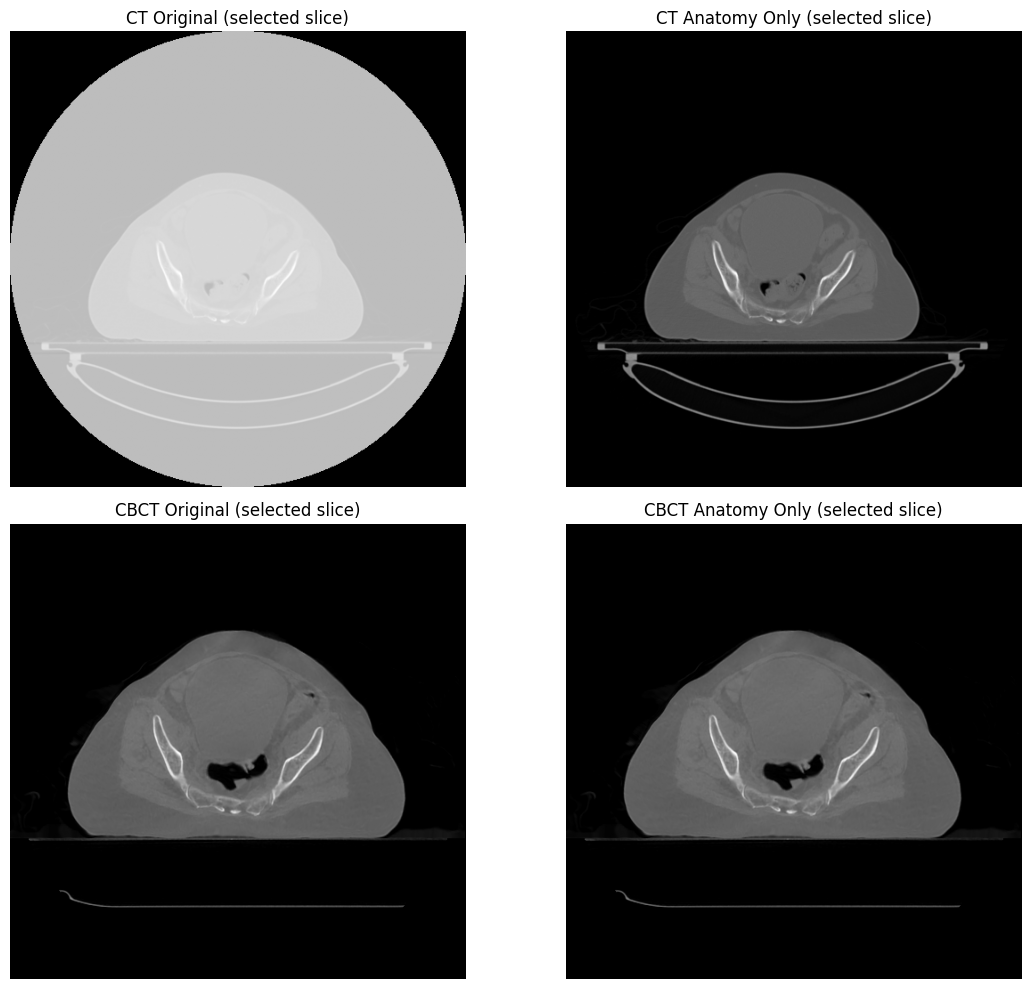

In [113]:
###################
# Main Execution  #
###################

if __name__ == "__main__":
    # Define folder pairs for raw and processed (anatomy only) DICOM files.
    folder_pairs = {
        "../data/raw/CBCT": "../data/hf/CBCT",
        "../data/raw/CT": "../data/hf/CT"
    }
    
    # Define the HU clipping range.
    hu_range = (-1000, 3000)
    
    # Process each folder pair.
    for input_folder, output_folder in folder_pairs.items():
        print(f"Processing folder: {input_folder} -> {output_folder}")
        process_dicom_folder(input_folder, output_folder, hu_range)

    # Load and sort DICOM file paths for each modality and processing type.
    ct_files_raw   = load_and_sort_dicom_files("../data/raw/CT")
    ct_files_hf    = load_and_sort_dicom_files("../data/hf/CT")
    cbct_files_raw = load_and_sort_dicom_files("../data/raw/CBCT")
    cbct_files_hf  = load_and_sort_dicom_files("../data/hf/CBCT")
    
    # Use the CT raw median slice as the reference anatomical level.
    target_z = compute_median_z(ct_files_raw)
    
    # Find the slice indices closest to the reference for each dataset.
    ct_index_raw   = find_closest_slice_index(ct_files_raw, target_z)
    ct_index_hf    = find_closest_slice_index(ct_files_hf, target_z)
    cbct_index_raw = find_closest_slice_index(cbct_files_raw, target_z)
    cbct_index_hf  = find_closest_slice_index(cbct_files_hf, target_z)
    
    # Load the selected slices.
    dicom_data_raw_ct = pydicom.dcmread(ct_files_raw[ct_index_raw])
    image_raw_ct = dicom_data_raw_ct.pixel_array

    dicom_data_hf_ct = pydicom.dcmread(ct_files_hf[ct_index_hf])
    image_hf_ct = dicom_data_hf_ct.pixel_array

    dicom_data_raw_cbct = pydicom.dcmread(cbct_files_raw[cbct_index_raw])
    image_raw_cbct = dicom_data_raw_cbct.pixel_array

    dicom_data_hf_cbct = pydicom.dcmread(cbct_files_hf[cbct_index_hf])
    image_hf_cbct = dicom_data_hf_cbct.pixel_array

    ##########################
    # Display the Selected Slices
    ##########################
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.title("CT Original (selected slice)")
    plt.imshow(image_raw_ct, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 2, 2)
    plt.title("CT Anatomy Only (selected slice)")
    plt.imshow(image_hf_ct, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 2, 3)
    plt.title("CBCT Original (selected slice)")
    plt.imshow(image_raw_cbct, cmap="gray")
    plt.axis("off")
    
    plt.subplot(2, 2, 4)
    plt.title("CBCT Anatomy Only (selected slice)")
    plt.imshow(image_hf_cbct, cmap="gray")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


## Image Cropping

Processing ROI: Sigmoid colon
Processing ROI: Rectum
Processing ROI: Femur_Rt
Processing ROI: Femur_Lt
Processing ROI: Bowel
Processing ROI: Bladder
Processing ROI: PTV 50
Processing ROI: CTV LN
Processing ROI: BODY
Global intensity range across all slices: [-1000.0, 3000.0]
Processing ROI: AcqIsocenter
Processing ROI: InitLaserIso
Processing ROI: InitMatchIso
Processing ROI: BODY
Global intensity range across all slices: [-1000.0, 1489.0]
Saved ../data/hf_crop/CT/seg_CT_slice_000.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_001.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_002.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_003.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_004.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_005.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_006.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_007.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_008.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_009.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_010.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_011.dcm
Save

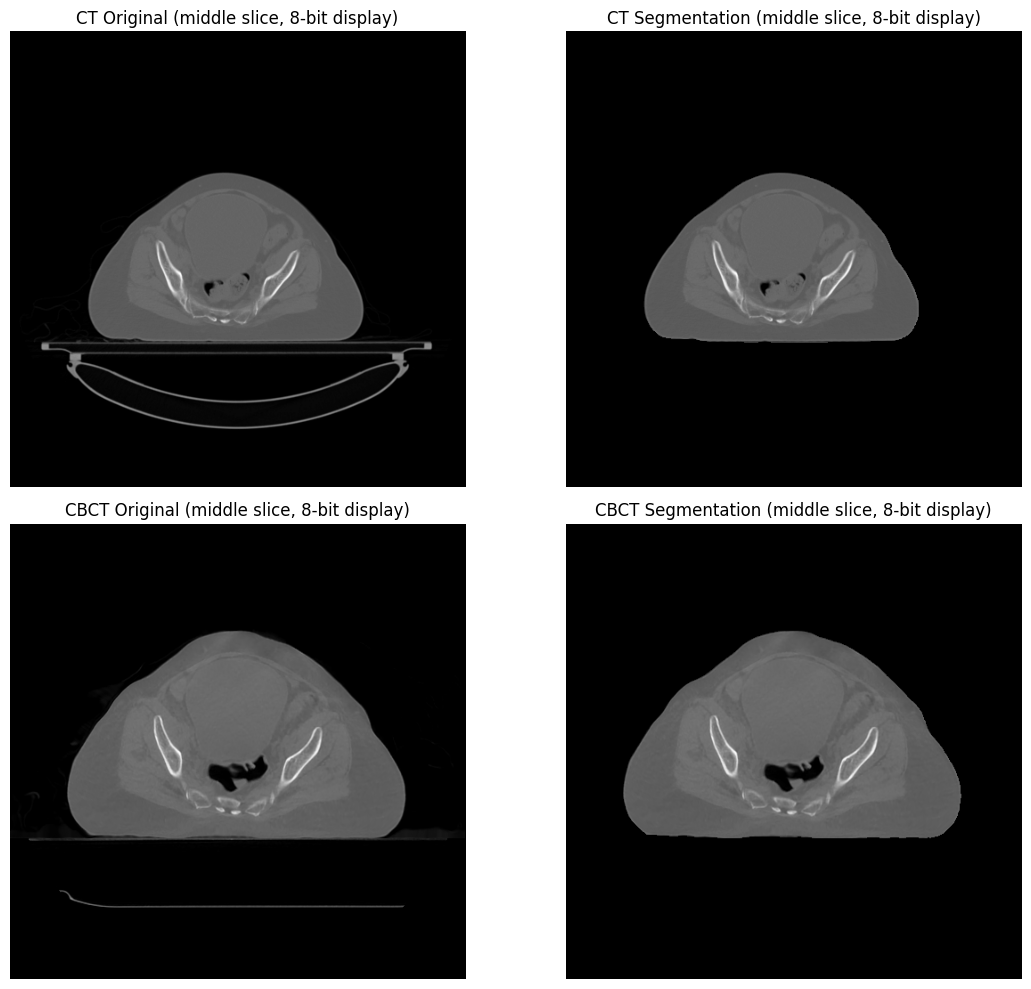

In [132]:
import os
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pydicom.uid import generate_uid

def world_to_pixel(coords, dicom_data):
    """
    Convert world (real-world) coordinates (in mm) to pixel coordinates using DICOM metadata.
    """
    spacing = dicom_data.PixelSpacing             # (x, y) pixel spacing in mm
    origin = dicom_data.ImagePositionPatient      # (x, y, z) image origin in mm
    pixel_coords = np.array([
        [(c[0] - origin[0]) / spacing[0], (c[1] - origin[1]) / spacing[1]]
        for c in coords
    ], dtype=np.int32)
    return pixel_coords

def get_roi_contours(rtstruct_data):
    """
    Extract ROI contours from an RTSTRUCT DICOM file.
    
    Returns:
        List of numpy arrays, each array containing the contour coordinates (x, y, z).
    """
    roi_contours = []
    for roi in rtstruct_data.StructureSetROISequence:
        print(f"Processing ROI: {roi.ROIName}")
    for roi_contour in rtstruct_data.ROIContourSequence:
        for contour_seq in roi_contour.ContourSequence:
            contour_data = np.array(contour_seq.ContourData).reshape(-1, 3)
            roi_contours.append(contour_data)
    return roi_contours

def process_dicom_series_from_folder(folder_path, tol=1e-2):
    """
    Process a DICOM series (a folder) containing one RTSTRUCT file and multiple image slices.
    
    1) Identify the RTSTRUCT file vs. image slices.
    2) Read slices, sort them by z.
    3) Find global intensity min/max across all slices.
    4) Normalize slices using the global range to 8-bit (for display/mask creation).
    5) Create segmentation masks by matching contours with each slice's z coordinate.
       (Contours that match within 'tol' in z are drawn on the slice.)
       
    Returns:
        images:        list of 8-bit images for display
        segmentations: list of 8-bit segmentation masks (white where contour is filled)
        slices:        list of tuples [(dicom_dataset, z), ...] sorted by z
    """
    files = os.listdir(folder_path)
    image_files = []
    rtstruct_file = None
    
    # Identify RTSTRUCT file vs image slices
    for f in files:
        if f.lower().endswith('.dcm'):
            full_path = os.path.join(folder_path, f)
            ds = pydicom.dcmread(full_path, stop_before_pixels=True)
            modality = ds.get("Modality", "")
            if modality == "RTSTRUCT":
                rtstruct_file = full_path
            else:
                image_files.append(full_path)
    
    if rtstruct_file is None:
        raise ValueError(f"No RTSTRUCT file found in folder: {folder_path}")
    
    # Load RTSTRUCT and get contours
    rtstruct_data = pydicom.dcmread(rtstruct_file)
    roi_contours = get_roi_contours(rtstruct_data)
    
    # Read slices and sort by z
    slices = []
    for img_file in image_files:
        ds = pydicom.dcmread(img_file)
        z = ds.ImagePositionPatient[2]
        slices.append((ds, z))
    slices.sort(key=lambda x: x[1])  # sort by z
    
    # --- 1) Find global min and max across all slices ---
    all_intensities = []
    for ds, _ in slices:
        arr = ds.pixel_array.astype(np.float32)
        all_intensities.append(arr)
    
    all_values = np.concatenate([arr.flatten() for arr in all_intensities])
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    print(f"Global intensity range across all slices: [{global_min}, {global_max}]")
    
    # --- 2) Normalize each slice to 8-bit for display/mask creation ---
    images = []
    segmentations = []
    for ds, z in slices:
        arr = ds.pixel_array.astype(np.float32)
        
        # Normalize to 0-255 using the global range
        norm_arr = (arr - global_min) / (global_max - global_min)
        norm_arr = np.clip(norm_arr, 0.0, 1.0)
        image_8bit = (norm_arr * 255).astype(np.uint8)
        
        # Create a blank mask
        mask = np.zeros_like(image_8bit, dtype=np.uint8)
        
        # Draw contours for this z if matching
        match_found = False
        for contour in roi_contours:
            # If the difference in z is small enough, treat it as the same slice
            if abs(contour[0, 2] - z) < tol:
                pixel_contour = world_to_pixel(contour, ds)
                cv2.drawContours(mask, [pixel_contour], -1, 255, thickness=cv2.FILLED)
                match_found = True
        
        if not match_found:
            print(f"No ROI contours matched for slice at z = {z:.3f}")
        
        # "segmentations" array is the slice data masked by the contour
        segmentation = cv2.bitwise_and(image_8bit, image_8bit, mask=mask)
        
        images.append(image_8bit)
        segmentations.append(segmentation)
    
    return images, segmentations, slices

def save_segmentations_as_dicom(original_slices, segmentations, output_folder, prefix="seg"):
    """
    Save segmentation images as DICOM files, preserving the original data type
    (bit depth, pixel representation) from the original slices.
    
    The segmentation is stored in the same shape as the original slices, but
    we copy the relevant DICOM header information. We also generate a new UID
    for each slice.
    """
    os.makedirs(output_folder, exist_ok=True)
    
    for idx, (slice_info, seg_img_8bit) in enumerate(zip(original_slices, segmentations)):
        ds_original, _ = slice_info
        
        # Copy the original dataset
        ds_new = ds_original.copy()
        
        # Generate a new UID for the SOPInstance
        new_uid = generate_uid()
        ds_new.SOPInstanceUID = new_uid
        ds_new.file_meta.MediaStorageSOPInstanceUID = new_uid
        
        # -----------------------------------------
        # Preserve the original data type settings
        # -----------------------------------------
        bits_alloc = ds_original.BitsAllocated
        bits_stored = ds_original.BitsStored
        high_bit   = ds_original.HighBit
        pix_repr   = ds_original.PixelRepresentation
        ds_new.BitsAllocated = bits_alloc
        ds_new.BitsStored    = bits_stored
        ds_new.HighBit       = high_bit
        ds_new.PixelRepresentation = pix_repr
        
        # Depending on BitsAllocated / PixelRepresentation, convert seg_img_8bit to match
        # For example, if the original was 16-bit signed, we store the mask in 16-bit signed.
        if bits_alloc == 8:
            # 8-bit
            if pix_repr == 0:  # unsigned
                seg_img_final = seg_img_8bit.astype(np.uint8)
            else:              # signed
                seg_img_final = seg_img_8bit.astype(np.int8)
        elif bits_alloc == 16:
            # 16-bit
            if pix_repr == 0:  # unsigned
                seg_img_final = seg_img_8bit.astype(np.uint16)
            else:              # signed
                seg_img_final = seg_img_8bit.astype(np.int16)
        else:
            # Fallback (rare case where bits_alloc is something else)
            seg_img_final = seg_img_8bit.astype(np.uint16)
        
        # Update pixel data
        ds_new.PixelData = seg_img_final.tobytes()
        
        # Keep the original PhotometricInterpretation if it’s grayscale
        # (often 'MONOCHROME2' for CT). If unsure, you could explicitly set it.
        # ds_new.PhotometricInterpretation = "MONOCHROME2"
        
        # Ensure the Rows/Columns match the segmentation shape
        ds_new.Rows, ds_new.Columns = seg_img_final.shape
        
        out_filename = os.path.join(output_folder, f"{prefix}_slice_{idx:03d}.dcm")
        ds_new.save_as(out_filename)
        print(f"Saved {out_filename}")

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    ct_input_folder = "../data/hf/CT"
    cbct_input_folder = "../data/hf/CBCT"
    
    ct_output_folder = "../data/hf_crop/CT"
    cbct_output_folder = "../data/hf_crop/CBCT"
    
    # Process CT
    ct_images, ct_segmentations, ct_slices = process_dicom_series_from_folder(
        ct_input_folder, tol=1e-2
    )
    # Process CBCT
    cbct_images, cbct_segmentations, cbct_slices = process_dicom_series_from_folder(
        cbct_input_folder, tol=1e-2
    )

    # Save segmentation outputs as new DICOM files using the *original* datatype
    save_segmentations_as_dicom(ct_slices, ct_segmentations, ct_output_folder, prefix="seg_CT")
    save_segmentations_as_dicom(cbct_slices, cbct_segmentations, cbct_output_folder, prefix="seg_CBCT")

    # Display the middle slices (optional)
    ct_mid = len(ct_images) // 2 if ct_images else 0
    cbct_mid = len(cbct_images) // 2 if cbct_images else 0
    
    plt.figure(figsize=(12, 10))

    if ct_images:
        plt.subplot(2, 2, 1)
        plt.title("CT Original (middle slice, 8-bit display)")
        plt.imshow(ct_images[ct_mid], cmap="gray")
        plt.axis('off')
        
        plt.subplot(2, 2, 2)
        plt.title("CT Segmentation (middle slice, 8-bit display)")
        plt.imshow(ct_segmentations[ct_mid], cmap="gray")
        plt.axis('off')
    
    if cbct_images:
        plt.subplot(2, 2, 3)
        plt.title("CBCT Original (middle slice, 8-bit display)")
        plt.imshow(cbct_images[cbct_mid], cmap="gray")
        plt.axis('off')
        
        plt.subplot(2, 2, 4)
        plt.title("CBCT Segmentation (middle slice, 8-bit display)")
        plt.imshow(cbct_segmentations[cbct_mid], cmap="gray")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Processing ROI: Sigmoid colon
Processing ROI: Rectum
Processing ROI: Femur_Rt
Processing ROI: Femur_Lt
Processing ROI: Bowel
Processing ROI: Bladder
Processing ROI: PTV 50
Processing ROI: CTV LN
Processing ROI: BODY
Global intensity range across all slices: [-1000.0, 3000.0]
Processing ROI: AcqIsocenter
Processing ROI: InitLaserIso
Processing ROI: InitMatchIso
Processing ROI: BODY
Global intensity range across all slices: [-1000.0, 1489.0]
Saved ../data/hf_crop/CT/seg_CT_slice_000.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_001.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_002.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_003.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_004.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_005.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_006.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_007.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_008.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_009.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_010.dcm
Saved ../data/hf_crop/CT/seg_CT_slice_011.dcm
Save

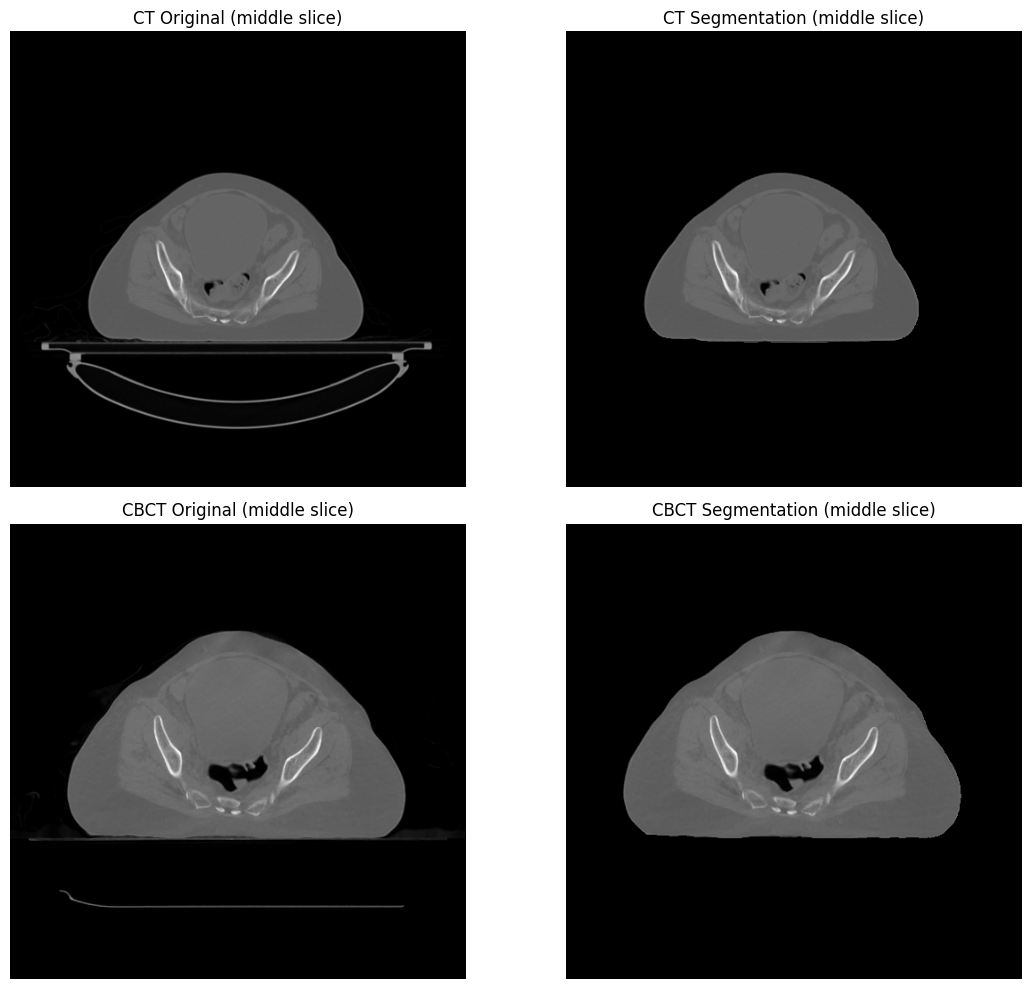

In [133]:

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    ct_input_folder = "../data/hf/CT"
    cbct_input_folder = "../data/hf/CBCT"
    
    ct_output_folder = "../data/hf_crop/CT"
    cbct_output_folder = "../data/hf_crop/CBCT"
    
    # Process CT
    ct_images, ct_segmentations, ct_slices = process_dicom_series_from_folder(
        ct_input_folder, tol=1e-2
    )
    # Process CBCT
    cbct_images, cbct_segmentations, cbct_slices = process_dicom_series_from_folder(
        cbct_input_folder, tol=1e-2
    )

    # Save segmentation outputs as new DICOM files with original datatype
    save_segmentations_as_dicom(ct_slices, ct_segmentations, ct_output_folder, prefix="seg_CT")
    save_segmentations_as_dicom(cbct_slices, cbct_segmentations, cbct_output_folder, prefix="seg_CBCT")

    # Display middle slices (optional)
    ct_mid = len(ct_images) // 2 if ct_images else 0
    cbct_mid = len(cbct_images) // 2 if cbct_images else 0
    
    plt.figure(figsize=(12, 10))

    if ct_images:
        plt.subplot(2, 2, 1)
        plt.title("CT Original (middle slice)")
        plt.imshow(ct_images[ct_mid], cmap="gray")
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title("CT Segmentation (middle slice)")
        plt.imshow(ct_segmentations[ct_mid], cmap="gray")
        plt.axis('off')
    
    if cbct_images:
        plt.subplot(2, 2, 3)
        plt.title("CBCT Original (middle slice)")
        plt.imshow(cbct_images[cbct_mid], cmap="gray")
        plt.axis('off')
        plt.subplot(2, 2, 4)
        plt.title("CBCT Segmentation (middle slice)")
        plt.imshow(cbct_segmentations[cbct_mid], cmap="gray")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()